In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold,cross_val_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
from bayes_opt import BayesianOptimization
from tqdm import tqdm_notebook as tqdm

import gc
gc.enable()

In [2]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    print (categorical_columns)
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

print('Read data and test')
data = pd.read_csv('./input/application_train.csv')
test = pd.read_csv('./input/application_test.csv')
print('data test Shapes : ', data.shape, test.shape)

y = data['TARGET']
del data['TARGET']
gc.collect()
all_data = pd.concat((data, test)).reset_index(drop=True)

inc_by_org = all_data[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']
all_data['NEW_INC_BY_ORG'] = all_data['ORGANIZATION_TYPE'].map(inc_by_org)
print('all_data Shape : ', all_data.shape)

for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    all_data[bin_feature], uniques = pd.factorize(all_data[bin_feature])
all_data, cat_cols = one_hot_encoder(all_data)
print('all_data Shape : ', all_data.shape)
# Some simple new features (percentages)
#all_data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
n_data = data.shape[0]

all_data['INCOME_DAYS_PERC'] = all_data['AMT_INCOME_TOTAL'] / all_data['DAYS_BIRTH']
all_data['DAYS_EMPLOYED_PERC'] = all_data['DAYS_EMPLOYED'] / all_data['DAYS_BIRTH']
all_data['INCOME_CREDIT_PERC'] = all_data['AMT_INCOME_TOTAL'] / all_data['AMT_CREDIT']
all_data['INCOME_PER_PERSON'] = all_data['AMT_INCOME_TOTAL'] / all_data['CNT_FAM_MEMBERS']
all_data['ANNUITY_INCOME_PERC'] = all_data['AMT_ANNUITY'] / all_data['AMT_INCOME_TOTAL']
all_data['PAYMENT_RATE'] = all_data['AMT_CREDIT'] / all_data['AMT_ANNUITY']
print('all_data Shape : ', all_data.shape)
del data,test
gc.collect()

bureau = pd.read_csv('./input/bureau.csv')
buro_bal = pd.read_csv('./input/bureau_balance.csv')
print('bureau  buro_bal Shape : ', bureau.shape,buro_bal.shape)
buro_bal, bb_cat = one_hot_encoder(buro_bal)
bureau, bureau_cat = one_hot_encoder(bureau)
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max','mean']}
for col in bb_cat:
    bb_aggregations[col] = ['mean']
    bb_agg = buro_bal.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
bb_agg['BB_COUNT'] = buro_bal.groupby('SK_ID_BUREAU').size()
print('bb_agg Shape : ', bb_agg.shape)
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(columns= 'SK_ID_BUREAU', inplace= True)
print('bureau Shape : ', bureau.shape)
del buro_bal,bb_agg
gc.collect()
bureau['PEC_ANNUITY_DEBT'] = bureau['AMT_ANNUITY']/bureau['AMT_CREDIT_SUM_DEBT']
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'CNT_CREDIT_PROLONG': ['sum','mean'],
    'PEC_ANNUITY_DEBT':['min','max','mean'],
    'AMT_CREDIT_SUM': ['max','mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max','mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'DAYS_CREDIT_UPDATE': ['min','max','mean'],
    'AMT_ANNUITY': ['max', 'mean'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_MEAN': ['mean'],
    'BB_COUNT': ['mean', 'sum']
}
cat_aggregations = {}
for cat in bureau_cat: cat_aggregations[cat] = ['mean']
for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
bureau_agg = bureau.groupby('SK_ID_CURR').agg(dict(num_aggregations, **cat_aggregations))
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
bureau_agg['BURO_COUNT'] = bureau.groupby('SK_ID_CURR').size()
bureau_agg['BURO_MAX_OVERDUE_DEBT'] = bureau_agg['BURO_AMT_CREDIT_MAX_OVERDUE_MEAN']/bureau_agg['BURO_AMT_CREDIT_SUM_DEBT_MEAN']
print('bureau_agg Shape : ', bureau_agg.shape)

active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACT_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
active_agg['ACT_COUNT'] = active.groupby('SK_ID_CURR').size()
bureau_agg = bureau_agg.reset_index().join(active_agg, how='left', on='SK_ID_CURR')
print('bureau_agg Shape : ', bureau_agg.shape)
del active, active_agg
gc.collect()

closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(dict({'DAYS_ENDDATE_FACT': ['min','max','mean']},**num_aggregations))
closed_agg.columns = pd.Index(['CLS_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
closed_agg['CLS_COUNT'] = closed.groupby('SK_ID_CURR').size()
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
print('bureau_agg Shape : ', bureau_agg.shape)
del closed, closed_agg
gc.collect()

for days in [1462,730,365,183]:
    stat = bureau[bureau['DAYS_CREDIT']>-days].copy()
    agg = {
        'DAYS_CREDIT': ['count','mean','skew'],
        #'DAYS_ENDDATE_FACT_diff':['max'],
        'AMT_CREDIT_MAX_OVERDUE': ['max'],
        #'AMT_CREDIT_SUM_DEBT_diff': ['min', 'max', 'mean', 'sum', 'std', 'median', 'skew', 'last', 'first', ss.kurtosis, np.ptp],
        'AMT_CREDIT_SUM':['sum'],
        'AMT_CREDIT_SUM_DEBT':['sum'],
        'AMT_CREDIT_SUM_LIMIT':['mean'],
    }

    stat_agg = stat.groupby('SK_ID_CURR').agg(agg)
    stat_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in stat_agg.columns.tolist()])
    stat_agg['AMT_CREDIT_SUM_DEBT_sum_ratio'] = stat_agg['AMT_CREDIT_SUM_SUM'] / (stat_agg['AMT_CREDIT_SUM_DEBT_SUM'] + 0.01)
    stat_agg.columns = [c + '_{}days_ago'.format(days) for c in stat_agg.columns]
    bureau_agg = bureau_agg.join(stat_agg, how='left', on='SK_ID_CURR')  
    print('bureau_agg Shape : ', bureau_agg.shape)
    del stat, stat_agg
    gc.collect()  

all_data = all_data.merge(bureau_agg, how='left', on='SK_ID_CURR')
print('all_data Shape : ', all_data.shape)
del bureau_agg
gc.collect()

prev = pd.read_csv('./input/previous_application.csv')
print('prev Shape : ', prev.shape)
prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
# Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
# Add feature: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
prev['NEW_PA_AMT_UNREPAID'] = prev[prev['DAYS_LAST_DUE_1ST_VERSION'] > 0]\
    ['DAYS_LAST_DUE_1ST_VERSION']/30*(prev[prev['DAYS_LAST_DUE_1ST_VERSION'] > 0]['AMT_ANNUITY'])
# Previous applications numeric features
num_aggregations = {
    'AMT_ANNUITY': ['min','max', 'mean'],
    'AMT_APPLICATION': ['min','max', 'mean'],
    'AMT_CREDIT': ['min','max', 'mean'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'SELLERPLACE_AREA': ['min', 'max', 'mean'],
    'DAYS_FIRST_DRAWING': ['min', 'max', 'mean'],
    'DAYS_FIRST_DUE': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE': ['min', 'max', 'mean'],
    'DAYS_TERMINATION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
    'NEW_PA_AMT_UNREPAID':['min','max','mean', 'sum']
}
# Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

prev_agg = prev.groupby('SK_ID_CURR').agg(dict(num_aggregations, **cat_aggregations))
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
prev_agg['PREV_COUNT'] = prev.groupby('SK_ID_CURR').size()
print('prev_agg Shape : ', prev_agg.shape)
# Previous Applications: Approved Applications - only numerical features

ap_num_aggregations = {
        'AMT_ANNUITY': ['min','max', 'mean'],
        'AMT_APPLICATION': ['min','max', 'mean'],
        'AMT_CREDIT': ['min','max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'SELLERPLACE_AREA': ['min', 'max', 'mean'],
        'DAYS_FIRST_DRAWING': ['min', 'max', 'mean'],
        'DAYS_FIRST_DUE': ['min', 'max', 'mean'],
        'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
        'DAYS_LAST_DUE': ['min', 'max', 'mean'],
        'DAYS_TERMINATION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum']
    }
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APR_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
approved_agg['APR_COUNT'] = approved.groupby('SK_ID_CURR').size()
prev_agg = prev_agg.reset_index().join(approved_agg, how='left', on='SK_ID_CURR')
print('prev_agg Shape : ', prev_agg.shape)
# Previous Applications: Refused Applications - only numerical features
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REF_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
refused_agg['REF_COUNT'] = refused.groupby('SK_ID_CURR').size()
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
print('prev_agg Shape : ', prev_agg.shape)
del refused, refused_agg, approved, approved_agg, prev
gc.collect()

all_data = all_data.merge(prev_agg, how='left', on='SK_ID_CURR')
print('all_data Shape : ', all_data.shape)
del prev_agg
gc.collect()

pos = pd.read_csv('./input/POS_CASH_balance.csv')
print('pos Shape : ', pos.shape)
pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
# Features
aggregations = {
    'MONTHS_BALANCE': ['min','max', 'mean'],
    'CNT_INSTALMENT': ['sum', 'mean'],
    'SK_DPD': ['sum','max','min','mean','size'],
    'SK_DPD_DEF': ['sum','max', 'min','mean','size']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']

pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
# Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
print('pos_agg Shape : ', pos_agg.shape)
del pos
gc.collect()

all_data = all_data.join(pos_agg, how='left', on='SK_ID_CURR')
print('all_data Shape : ', all_data.shape)
del pos_agg
gc.collect()

ins = pd.read_csv('./input/installments_payments.csv')
print('ins Shape : ', ins.shape)
ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['NEW_IP_DPD_RATIO'] = ins['DAYS_ENTRY_PAYMENT'] / ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['NEW_IP_DBD_RATIO'] = ins['DAYS_INSTALMENT'] / ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
# Features: Perform aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max','mean', 'sum'],
    'NEW_IP_DPD_RATIO':['max', 'mean','min'],
    'NEW_IP_DBD_RATIO':['max', 'mean','min'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum'],
    'DAYS_INSTALMENT': ['max', 'mean', 'sum']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']
ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
# Count installments accounts
ins_agg['INS_COUNT'] = ins.groupby('SK_ID_CURR').size()
print('ins_agg Shape : ', ins_agg.shape)
del ins
gc.collect()

all_data = all_data.join(ins_agg, how='left', on='SK_ID_CURR')
print('all_data Shape : ', all_data.shape)
del ins_agg
gc.collect()

cc = pd.read_csv('./input/credit_card_balance.csv')
print('cc Shape : ', cc.shape)
cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
# Features: Perform aggregations
num_aggregations = {
    'MONTHS_BALANCE': ['min','max', 'mean'],
    'AMT_BALANCE': ['min','max', 'mean','sum'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['min','max', 'mean','sum','var'],
    'AMT_DRAWINGS_ATM_CURRENT': ['min','max', 'mean','sum'],
    'AMT_DRAWINGS_CURRENT': ['min','max', 'mean','sum'],
    'AMT_DRAWINGS_OTHER_CURRENT': ['min','max', 'mean','sum'],
    'AMT_DRAWINGS_POS_CURRENT': ['min','max', 'mean','sum'],
    'AMT_INST_MIN_REGULARITY': ['min','max', 'mean','sum','var'],
    'AMT_PAYMENT_CURRENT':['min','max', 'mean','sum'],
    'AMT_PAYMENT_TOTAL_CURRENT':['min','max', 'mean','sum'],
    'AMT_RECEIVABLE_PRINCIPAL':['min','max', 'mean','sum','var'],
    'AMT_RECIVABLE':['min','max', 'mean','sum','var'],
    'AMT_TOTAL_RECEIVABLE':['min','max', 'mean','sum','var'],
    'CNT_DRAWINGS_ATM_CURRENT':['mean','sum'],
    'CNT_DRAWINGS_CURRENT':['mean','sum'],
    'CNT_DRAWINGS_OTHER_CURRENT':['mean','sum'],
    'CNT_DRAWINGS_POS_CURRENT':['mean','sum'],
    'CNT_INSTALMENT_MATURE_CUM':['mean','sum'],
    'SK_DPD':['max', 'mean', 'sum'],
    'SK_DPD_DEF':['max', 'mean', 'sum']
}
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']
# General aggregations
cc_agg = cc.groupby('SK_ID_CURR').agg(dict(num_aggregations,**cat_aggregations))
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
# Count credit card lines
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

#cc_agg['INSTALLMENTS_PER_LOAN'] = cc_agg['CNT_INSTALMENT_MATURE_CUM_SUM'] / cc_agg['CC_COUNT']
del cc
print('cc_agg Shape : ', cc_agg.shape)
gc.collect()

all_data = all_data.join(cc_agg, how='left', on='SK_ID_CURR')
print('all_data Shape : ', all_data.shape)
del cc_agg
gc.collect()

Read data and test
data test Shapes :  (307511, 122) (48744, 121)
all_data Shape :  (356255, 122)
['NAME_CONTRACT_TYPE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
all_data Shape :  (356255, 255)
all_data Shape :  (356255, 261)
bureau  buro_bal Shape :  (1716428, 17) (27299925, 3)
['STATUS']
['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
bb_agg Shape :  (817395, 13)
bureau Shape :  (1716428, 52)
bureau_agg Shape :  (305811, 71)
bureau_agg Shape :  (305811, 107)
bureau_agg Shape :  (305811, 145)
bureau_agg Shape :  (305811, 153)
bureau_agg Shape :  (305811, 161)
bureau_agg Shape :  (305811, 169)
bureau_agg Shape :  (305811, 177)
all_data Shape :  (356255, 437)
prev Shape :  (1670214, 37)
['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT'

7

In [3]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})

missing_data

drop_col = missing_data[missing_data['Missing Ratio']==100]
missing_data = missing_data[missing_data['Missing Ratio']<100]

all_data.drop(drop_col.index.values,1,inplace=True)

data = all_data[:n_data]
test = all_data[n_data:]
#del avg_buro, avg_prev,avg_pos,avg_cc_bal,avg_inst
del all_data
gc.collect()
print (data.shape)
print (test.shape)

exclude_fea = []
exclude_fea.append('SK_ID_CURR') 
exclude_fea

(307511, 879)
(48744, 879)


['SK_ID_CURR']

In [4]:
folds = KFold(n_splits=5, shuffle=True, random_state=1700)
oof_preds = np.zeros(data.shape[0])
sub_preds = np.zeros(test.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in data.columns if f not in exclude_fea]

In [4]:
NFOLDS=5
SEED = 1700
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)
feats = [f for f in data.columns if f not in exclude_fea]

In [9]:
def get_lgb_oof(x_train, y_train, x_test):
    oof_train = np.zeros((x_train.shape[0],))
    oof_test = np.zeros((x_test.shape[0],))
    oof_test_skf = np.empty((NFOLDS, x_test.shape[0]))

    for i, (train_index, test_index) in enumerate(folds.split(x_train)):
        x_tr = x_train[feats].iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_te = x_train[feats].iloc[test_index]
        y_te = y_train.iloc[test_index]
        clf = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.01,
            num_leaves=31,
            colsample_bytree=0.9338690,
            subsample=0.97291513,
            max_depth=8,
            reg_alpha=0.06663684,
            reg_lambda=0.0988343,
            min_split_gain=0.07916152,
            min_child_weight=82.8850799,
            random_state=1700,
        )
        clf.fit(x_tr, y_tr, 
            eval_set= [(x_tr, y_tr), (x_te, y_te)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=300  #30
           )

        oof_train[test_index] = clf.predict_proba(x_te, num_iteration=clf.best_iteration_)[:,1]
        oof_test_skf[i, :] = clf.predict_proba(x_test[feats], num_iteration=clf.best_iteration_)[:,1]
        print('Fold %2d Train AUC : %.6f' % (i + 1, roc_auc_score(y_tr, clf.predict_proba(x_tr, num_iteration=clf.best_iteration_)[:,1])))
        print('Fold %2d Test AUC : %.6f' % (i + 1, roc_auc_score(y_te, oof_train[test_index])))
        del clf,x_tr,y_tr,x_te,y_te
        gc.collect()
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [10]:
oof_train, oof_test = get_lgb_oof(data, y, test)

Training until validation scores don't improve for 300 rounds.
[100]	training's auc: 0.742489	valid_1's auc: 0.731959
[200]	training's auc: 0.75319	valid_1's auc: 0.740422
[300]	training's auc: 0.768026	valid_1's auc: 0.752129
[400]	training's auc: 0.783229	valid_1's auc: 0.763588
[500]	training's auc: 0.794566	valid_1's auc: 0.771642
[600]	training's auc: 0.802785	valid_1's auc: 0.777209
[700]	training's auc: 0.809425	valid_1's auc: 0.78123
[800]	training's auc: 0.814982	valid_1's auc: 0.784034
[900]	training's auc: 0.819639	valid_1's auc: 0.786062
[1000]	training's auc: 0.823834	valid_1's auc: 0.7876
[1100]	training's auc: 0.827775	valid_1's auc: 0.788714
[1200]	training's auc: 0.831249	valid_1's auc: 0.789611
[1300]	training's auc: 0.834535	valid_1's auc: 0.790387
[1400]	training's auc: 0.837581	valid_1's auc: 0.791104
[1500]	training's auc: 0.840355	valid_1's auc: 0.791689
[1600]	training's auc: 0.843004	valid_1's auc: 0.792272
[1700]	training's auc: 0.845692	valid_1's auc: 0.79275

[800]	training's auc: 0.814914	valid_1's auc: 0.786158
[900]	training's auc: 0.81965	valid_1's auc: 0.78815
[1000]	training's auc: 0.823795	valid_1's auc: 0.789584
[1100]	training's auc: 0.827507	valid_1's auc: 0.79059
[1200]	training's auc: 0.830976	valid_1's auc: 0.791381
[1300]	training's auc: 0.834139	valid_1's auc: 0.792046
[1400]	training's auc: 0.837076	valid_1's auc: 0.792568
[1500]	training's auc: 0.840058	valid_1's auc: 0.792977
[1600]	training's auc: 0.842818	valid_1's auc: 0.793417
[1700]	training's auc: 0.845466	valid_1's auc: 0.793789
[1800]	training's auc: 0.848097	valid_1's auc: 0.794027
[1900]	training's auc: 0.850521	valid_1's auc: 0.794258
[2000]	training's auc: 0.85298	valid_1's auc: 0.794532
[2100]	training's auc: 0.855424	valid_1's auc: 0.794817
[2200]	training's auc: 0.85773	valid_1's auc: 0.795008
[2300]	training's auc: 0.859903	valid_1's auc: 0.795182
[2400]	training's auc: 0.862001	valid_1's auc: 0.795265
[2500]	training's auc: 0.864057	valid_1's auc: 0.795357

In [5]:
def get_xgb_oof(x_train, y_train, x_test):
    oof_train = np.zeros((x_train.shape[0],))
    oof_test = np.zeros((x_test.shape[0],))
    oof_test_skf = np.empty((NFOLDS, x_test.shape[0]))

    for i, (train_index, test_index) in enumerate(folds.split(x_train)):
        x_tr = x_train[feats].iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_te = x_train[feats].iloc[test_index]
        y_te = y_train.iloc[test_index]
        clf = XGBClassifier(learning_rate =0.01,
                            n_estimators=10000, 
                            max_depth=4, 
                            min_child_weight=5, 
                            subsample=0.8, 
                            colsample_bytree=0.8,
                            objective= 'binary:logistic', 
                            scale_pos_weight=2.5, 
                            random_state=SEED,
                            reg_lambda = 1.2,
                            tree_method='gpu_hist')

        clf.fit(x_tr, y_tr, eval_set=[(x_tr, y_tr), (x_te, y_te)], 
                eval_metric= 'auc', verbose= 100, early_stopping_rounds= 300)

        oof_train[test_index] = clf.predict_proba(x_te)[:,1]
        oof_test_skf[i, :] = clf.predict_proba(x_test[feats])[:,1]
        print('Fold %2d Train AUC : %.6f' % (i + 1, roc_auc_score(y_tr, clf.predict_proba(x_tr)[:,1])))
        print('Fold %2d Test AUC : %.6f' % (i + 1, roc_auc_score(y_te, oof_train[test_index])))
        del clf,x_tr,y_tr,x_te,y_te
        gc.collect()
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [6]:
oof_train, oof_test = get_xgb_oof(data, y, test)

[0]	validation_0-auc:0.703699	validation_1-auc:0.698048
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.737183	validation_1-auc:0.729401
[200]	validation_0-auc:0.75055	validation_1-auc:0.740859
[300]	validation_0-auc:0.76383	validation_1-auc:0.752257
[400]	validation_0-auc:0.774797	validation_1-auc:0.761078
[500]	validation_0-auc:0.782732	validation_1-auc:0.767093
[600]	validation_0-auc:0.788767	validation_1-auc:0.771541
[700]	validation_0-auc:0.793647	validation_1-auc:0.774895
[800]	validation_0-auc:0.797645	validation_1-auc:0.777439
[900]	validation_0-auc:0.801248	validation_1-auc:0.779569
[1000]	validation_0-auc:0.804457	validation_1-auc:0.781212
[1100]	validation_0-auc:0.807377	validation_1-auc:0.78267
[1200]	validation_0-auc:0.809981	validation_1-auc:0.783821
[1300]	validation_0-auc:0.812383	validation_1-auc:0.784832
[1400]	validation_0-auc:0.81468

[1900]	validation_0-auc:0.824817	validation_1-auc:0.789444
[2000]	validation_0-auc:0.82671	validation_1-auc:0.789795
[2100]	validation_0-auc:0.828422	validation_1-auc:0.790154
[2200]	validation_0-auc:0.830248	validation_1-auc:0.790486
[2300]	validation_0-auc:0.831996	validation_1-auc:0.790851
[2400]	validation_0-auc:0.83363	validation_1-auc:0.791045
[2500]	validation_0-auc:0.835247	validation_1-auc:0.791279
[2600]	validation_0-auc:0.836822	validation_1-auc:0.7914
[2700]	validation_0-auc:0.838356	validation_1-auc:0.791559
[2800]	validation_0-auc:0.839828	validation_1-auc:0.79174
[2900]	validation_0-auc:0.841405	validation_1-auc:0.791888
[3000]	validation_0-auc:0.842801	validation_1-auc:0.791974
[3100]	validation_0-auc:0.844239	validation_1-auc:0.792019
[3200]	validation_0-auc:0.845616	validation_1-auc:0.79215
[3300]	validation_0-auc:0.84696	validation_1-auc:0.792279
[3400]	validation_0-auc:0.848375	validation_1-auc:0.792363
[3500]	validation_0-auc:0.849724	validation_1-auc:0.792474
[360

[2400]	validation_0-auc:0.834278	validation_1-auc:0.786948
[2500]	validation_0-auc:0.835916	validation_1-auc:0.787174
[2600]	validation_0-auc:0.837499	validation_1-auc:0.787418
[2700]	validation_0-auc:0.839009	validation_1-auc:0.787704
[2800]	validation_0-auc:0.840396	validation_1-auc:0.787872
[2900]	validation_0-auc:0.841838	validation_1-auc:0.788115
[3000]	validation_0-auc:0.843394	validation_1-auc:0.788339
[3100]	validation_0-auc:0.844799	validation_1-auc:0.788479
[3200]	validation_0-auc:0.846216	validation_1-auc:0.788605
[3300]	validation_0-auc:0.847572	validation_1-auc:0.788691
[3400]	validation_0-auc:0.848931	validation_1-auc:0.788839
[3500]	validation_0-auc:0.850272	validation_1-auc:0.788952
[3600]	validation_0-auc:0.851618	validation_1-auc:0.789035
[3700]	validation_0-auc:0.852913	validation_1-auc:0.789187
[3800]	validation_0-auc:0.854191	validation_1-auc:0.789334
[3900]	validation_0-auc:0.855435	validation_1-auc:0.78942
[4000]	validation_0-auc:0.8567	validation_1-auc:0.789487


In [7]:
oof_train_csv = pd.DataFrame()
oof_train_csv['ID'] = data.SK_ID_CURR
oof_train_csv['xgb_oof_train'] = oof_train

oof_train_csv.to_csv('./output/xgb_oof_train3.csv', index=False)

oof_test_csv = pd.DataFrame()
oof_test_csv['ID'] = test.SK_ID_CURR
oof_test_csv['xgb_oof_test'] = oof_test

oof_test_csv.to_csv('./output/xgb_oof_test3.csv', index=False)

In [ ]:
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(data)):
    trn_x, trn_y = data[feats].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = data[feats].iloc[val_idx], y.iloc[val_idx]
    
    clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.01,
        num_leaves=31,
        colsample_bytree=0.9338690,
        subsample=0.97291513,
        max_depth=8,
        reg_alpha=0.06663684,
        reg_lambda=0.0988343,
        min_split_gain=0.07916152,
        min_child_weight=82.8850799,
        random_state=1700,
    )
    clf.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=300  #30
           )
    
    oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
    del clf, trn_x, trn_y, val_x, val_y
    gc.collect()
    
print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

Training until validation scores don't improve for 300 rounds.
[100]	training's auc: 0.743163	valid_1's auc: 0.732666
[200]	training's auc: 0.753149	valid_1's auc: 0.740641
[300]	training's auc: 0.768547	valid_1's auc: 0.752516
[400]	training's auc: 0.784311	valid_1's auc: 0.764422
[500]	training's auc: 0.795702	valid_1's auc: 0.77257


In [6]:
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(data)):
    trn_x, trn_y = data[feats].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = data[feats].iloc[val_idx], y.iloc[val_idx]
    
    clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.01,
        num_leaves=31,
        colsample_bytree=0.9338690,
        subsample=0.97291513,
        max_depth=8,
        reg_alpha=0.06663684,
        reg_lambda=0.0988343,
        min_split_gain=0.07916152,
        min_child_weight=82.8850799,
        random_state=1700,
    )
    clf.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=300  #30
           )
    
    oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
    del clf, trn_x, trn_y, val_x, val_y
    gc.collect()
    
print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

Training until validation scores don't improve for 300 rounds.
[100]	training's auc: 0.742838	valid_1's auc: 0.732527
[200]	training's auc: 0.753141	valid_1's auc: 0.74064
[300]	training's auc: 0.768644	valid_1's auc: 0.752598
[400]	training's auc: 0.7842	valid_1's auc: 0.764355
[500]	training's auc: 0.795634	valid_1's auc: 0.772435
[600]	training's auc: 0.803951	valid_1's auc: 0.778038
[700]	training's auc: 0.810601	valid_1's auc: 0.781943
[800]	training's auc: 0.816244	valid_1's auc: 0.784882
[900]	training's auc: 0.821074	valid_1's auc: 0.786905
[1000]	training's auc: 0.825134	valid_1's auc: 0.788235
[1100]	training's auc: 0.829091	valid_1's auc: 0.78947
[1200]	training's auc: 0.832595	valid_1's auc: 0.790383
[1300]	training's auc: 0.83586	valid_1's auc: 0.791198
[1400]	training's auc: 0.838794	valid_1's auc: 0.79185
[1500]	training's auc: 0.841554	valid_1's auc: 0.792315
[1600]	training's auc: 0.844341	valid_1's auc: 0.792798
[1700]	training's auc: 0.84701	valid_1's auc: 0.793243
[

KeyboardInterrupt: 

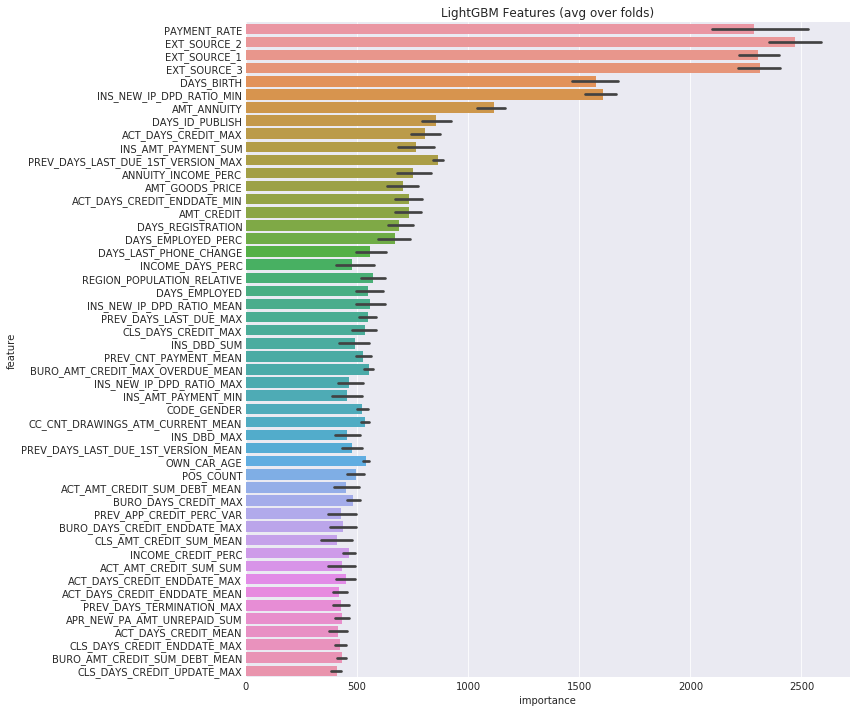

In [9]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[0:50].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(12, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances-7952.png')

In [6]:
test['TARGET'] = sub_preds

test[['SK_ID_CURR', 'TARGET']].to_csv('submission7952.csv', index=False)

In [7]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[0:50].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(12, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
#plt.savefig('lgbm_importances-7952.png')

KeyError: "['feature' 'importance'] not in index"